In [191]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


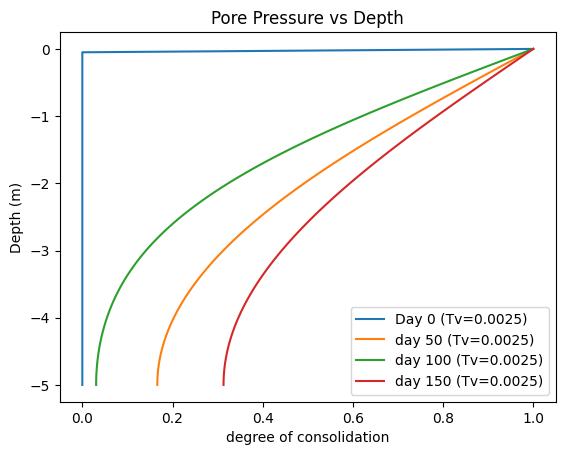

In [192]:
H = 5
num = 100
nodes = num + 1
P = 100
Tx = 60*60*24*365
time_step = 100
dt = Tx / time_step
Cv = 2e-7

time_factor = (Cv * dt) / H**2

def create_local(Cv, Z):
    he = np.diff(Z)
    if np.round(he[0:1]) == np.round(he[1:2]):
        he = he[0:1]
        me = np.array([[2,1], [1,2]])
        Me = (he / 6) * me
        ke = np.array([[1,-1], [-1,1]])
        Ke = (Cv / he) * ke
        return Me, Ke 
    else:
        print("ERROR - 'he' not uniform")


def create_global(Matrix, num_nodes):
    num_nodes = int(num_nodes)
    Global_M = np.zeros((num_nodes,num_nodes))
    n = np.arange(num_nodes)
    for i in range(np.max(n)):
        i = int(i)
        Global_M[i : (i+2), i : (i+2)] += Matrix
    return Global_M


def boundary_conditions(LF, nodes):
    p = 0
    LF[:,p] = 0
    LF[p,:] = 0
    LF[p,p] = 1
    return LF


def solve_timestep(GMe, B, U0, time_step, nodes):
    p = 0
    GMe[:,p] = 0
    GMe[p,:] = 0
    GMe[p,p] = 1

    U0[p] = 0
    linear_form = GMe @ U0
    loop = np.arange(int(time_step))

    for i in loop:
        if i == 0: 
            pass
        elif i == 1:
            data = U0
            linear_form = GMe @ data
            linear_form[p] = 0
            Un = np.linalg.solve(B, linear_form)
            Un = np.array([Un])
            data = data.reshape(-1, 1).T
            data = np.concatenate((data,Un), axis=0)
        elif i > 1:
            Un = data[(i-1):i,:nodes]
            Un = Un.T
            linear_form = GMe @ Un 
            Un1 = np.linalg.solve(B, linear_form)
            Un1 = Un1.reshape(-1, 1).T
            data = np.concatenate((data,Un1), axis=0)
    return data
        
def interval_plotting():
    fig = plt.figure()
    axis = plt.axes(xlim = (0,4),
        ylim = (-2,2))
    line, = axis.plot([],[], lw = 3)

    fig = plt.figure()
    
    axis = plt.axes(xlim = (0,4),
                ylim = (-2,2))
    line, = axis.plot([],[], lw = 3)

    def init():
        line.set_data([],[])
        return line,

    def animate(i):
        x = np.linspace(0, 4, 1000)
        y = np.sin(2 * np.pi * (x - 0.01 * i))
        line.set_data(x,y)
    return line,


Z = -np.linspace(0, H, num = nodes)
U0 = P*np.ones(Z.shape, dtype=float)

Me, Ke = create_local(Cv = Cv, Z=Z)
GMe, GKe = create_global(Me, nodes), create_global(Ke, nodes)
bilinear_form = (GMe) + (dt * GKe)

B = boundary_conditions(bilinear_form, nodes)
data = solve_timestep(GMe, B, U0, time_step, nodes)

cdata = 1 - (data / P) 



plt.plot(cdata[0, :], Z, label = f"Day 0 (Tv={time_factor:.4f})")
plt.plot(cdata[int(2*time_step/3), :],Z, label= f"day 50 (Tv={time_factor:.4f})")
plt.plot(cdata[int(time_step/3), :],Z, label= f"day 100 (Tv={time_factor:.4f})")
plt.plot(cdata[(time_step-1), :],Z, label= f"day 150 (Tv={time_factor:.4f})")
plt.legend()
plt.xlabel("degree of consolidation")
plt.ylabel("Depth (m)")
plt.title("Pore Pressure vs Depth")
plt.show()




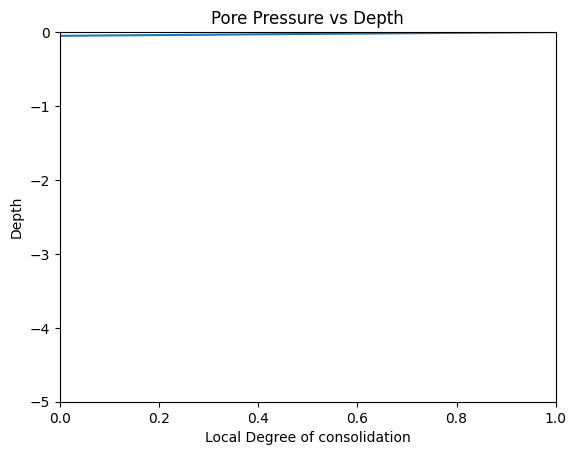

In [211]:
t= cdata
y = Z

fig, axis = plt.subplots()
axis.set_xlim(0,1)
axis.set_ylim(-5,0)
axis.set_xlabel("Local Degree of consolidation")
axis.set_ylabel("Depth")
plt.title("Pore Pressure vs Depth")

animated_plot, = axis.plot([],[])

def update_data(frame):
    animated_plot.set_data(t[frame:frame+1],y)
    return animated_plot, 

animation = FuncAnimation(fig = fig,
                          func =update_data,
                          frames = len(t),
                          interval=25                     
                          )

# animation.save("a.gif")
HTML(animation.to_jshtml())